#### Example: Downloading and writing to disk a raster map



In [1]:
import os
import pandas as pd, geopandas as gp, numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import shape
from rasterio.windows import from_bounds
from tqdm import tqdm

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
try: os.chdir('/home/jovyan/work/')
except: pass

In [3]:
quads_localfile = ('./data/elevation_quads.geojson')
msa_localfile = ('./data/msa1999_boundaries.shp')

In [4]:
elevation_quads = gp.read_file(quads_localfile)
msa_1999 = gp.read_file(msa_localfile).to_crs(elevation_quads.crs)

In [5]:
bounds = msa_1999.to_crs(elevation_quads.crs).dissolve().bounds.values[0]

In [8]:
elevation_quads = elevation_quads.cx[bounds[0]:bounds[2],bounds[3]:bounds[1]] #Trim elevation quads to the extent of the conterminous USA
truelist = []
for i in range(len(elevation_quads.index)):
    url = elevation_quads.iloc[i].downloadUrl
    truelist.append(len(url) > 0)
elevation_quads = elevation_quads[truelist] #Remove empty elements from the geodataframe

<AxesSubplot:>

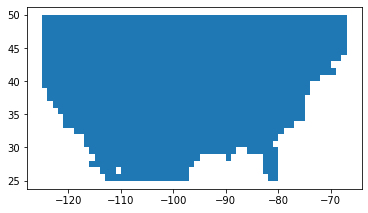

In [7]:
elevation_quads.plot()

<AxesSubplot:>

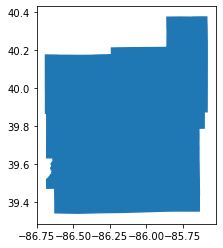

In [13]:
msa_1999[['Indianapolis' in name for name in msa_1999.NAME]].plot()

In [7]:
sample_raster = rasterio.open(elevation_quads.iloc[3].downloadUrl)
sample_array = sample_raster.read()[0,:,:]

In [14]:
elevation_quads = elevation_quads.sjoin(msa_1999[['Indianapolis' in name for name in msa_1999.NAME]])
elevation_quads

,title,label,available,downloadUrl,websiteUrl,size,geometry,index_right,FIPS,Cnt_FIPS,NAME,AREA_HA,XCOORD,YCOORD
86,USGS 1 Arc Second n40w086 20210617,n40w086,true,https://prd-tnm.s3.amazonaws.com/StagedProduct...,https://www.sciencebase.gov/catalog/item/60d2c...,50 MB,"POLYGON ((-86.00000 39.00000, -85.00000 39.000...",114,3480,1,"Indianapolis, IN",917267,-86.117349,39.807328
87,USGS 1 Arc Second n40w087 20210617,n40w087,true,https://prd-tnm.s3.amazonaws.com/StagedProduct...,https://www.sciencebase.gov/catalog/item/60d2c...,53 MB,"POLYGON ((-87.00000 39.00000, -86.00000 39.000...",114,3480,1,"Indianapolis, IN",917267,-86.117349,39.807328
104,USGS 1 Arc Second n41w086 20210617,n41w086,true,https://prd-tnm.s3.amazonaws.com/StagedProduct...,https://www.sciencebase.gov/catalog/item/60d2c...,49 MB,"POLYGON ((-86.00000 40.00000, -85.00000 40.000...",114,3480,1,"Indianapolis, IN",917267,-86.117349,39.807328
105,USGS 1 Arc Second n41w087 20210617,n41w087,true,https://prd-tnm.s3.amazonaws.com/StagedProduct...,https://www.sciencebase.gov/catalog/item/60d2c...,50 MB,"POLYGON ((-87.00000 40.00000, -86.00000 40.000...",114,3480,1,"Indianapolis, IN",917267,-86.117349,39.807328


In [9]:
elevation_bounds = elevation_quads.dissolve().bounds.values[0]
elevation_bounds

array([-87.,  39., -85.,  41.])



sample_array.shape

(3612, 3612)

In [10]:
transform_copy = rasterio.transform.from_bounds(elevation_bounds[0], elevation_bounds[1], elevation_bounds[2], elevation_bounds[3], 3600*2, 3600*2)

In [11]:
download_path = './data/indianapolis_elevation.tif'

Do the big download:

In [12]:
big_elevation_raster = rasterio.open(download_path, 
        'w', 
        driver = "GTiff", 
        dtype = sample_array.dtype, 
        height = 3600*2,
        width = 3600*2,
        nodata = 0, 
        count = 1,
        crs = elevation_quads.crs,
        transform = transform_copy,
        compress = 'DEFLATE',
        tiled=True, 
        blockxsize=256, 
        blockysize=256, 
        BIGTIFF='YES')
big_elevation_raster.close() ##Create the raster and close it
with rasterio.open(download_path, 'r+') as big_elevation_raster:
    print("Downloading elevation model to big geotiff")
    counter = tqdm(total=len(elevation_quads.index), desc = "Progress")
    for i in range(len(elevation_quads.index)):
        url = elevation_quads.iloc[i].downloadUrl  #Get URL of geotiff
        with rasterio.open(url) as rasterio_to_write: #Open geotiff
            bounds_to_write = elevation_quads.iloc[i].geometry.bounds
            #get bounds of geotiff to write
            rows, cols = rasterio.transform.rowcol(transform_copy, (bounds_to_write[0], bounds_to_write[2]), (bounds_to_write[3], bounds_to_write[1])) 
            #Get the columns and rows in big_elevation_raster from its transform and the bounds of the elevation geotiff
            data_to_write = rasterio_to_write.read(window = Window.from_slices(slice(6, 3606), slice(6, 3606))) #read the data itself
            writewindow = Window.from_slices(rows, cols)
            big_elevation_raster.write(data_to_write, window = writewindow)
        counter.update()
    counter.refresh()
    factors = [8,16,64]
    big_elevation_raster.build_overviews(factors, Resampling.nearest)
    big_elevation_raster.update_tags(ns='rio_overview', resampling='nearest')

Progress: 100%|███████████████████████████████████████████████████████████████████████████| 4/4 [01:14<00:00, 20.98s/it]

In [13]:
with rasterio.open(download_path, 'r+') as elevation:
    factors = [8,16,64]
    elevation.build_overviews(factors, Resampling.nearest)
    elevation.update_tags(ns='rio_overview', resampling='nearest')